# Code Demonstration: Bayesian Optimization for Zeolite Synthesis

Author: Plessers Dieter  
March 28th, 2024

## Table of Contents    <a name='TOC'></a> 
[Introduction](#Introduction)   
[Import necessary packages](#Packages)   

[Part 1: Optimize an Analytical 'Dummy' Function with Zeolite Synthesis Parameters](#Part1)
* [1.1 Define Dummy Analytical Objective Functions](#Part1.1)    
* [1.2 Define a Function that Optimizes the Dummy Function with Ax Package](#Part1.2)
* [1.3 Single-Objective with 4 Continuous Variables](#Part1.3)    
* [1.4 Multi-Objective with 4 Continuous Variables](#Part1.4)
* [1.5 Multi-Objective with 4 Continuous Variables and 2 Categorical Variables](#Part1.5)    
* [1.6 Multi-Objective with 4 Continuous Variables, 2 Categorical Variables and Parameter Constraints](#Part1.6)
* [1.7 Code Example without Using the General `optimize_experiment_ax` Function of Part 1.2](#Part1.7)
  
[Part 2: Propose a New Experiment Based on a Batch of Prior (Literature) Experiments](#Part2)
* [2.1 Define a Function that Proposes the Next Best Experiment with Ax Package](#Part2.1)    
* [2.2 Collect the Literature Input and Output Data](#Part2.2)
* [2.3 Single-Objective (Synthesis Yield) with 3 Continuous Variables and 2 Categorical Variables](#Part2.3)    
* [2.4 Multi-Objective (Synthesis Yield + Methanol Production) with 3 Continuous Variables and 2 Categorical Variables](#Part2.4)


## Introduction <a name='Introduction'></a> 
#### Scope 
This Jupyter notebook accompanies an introductory text on Bayesian optimization (BO) for zeolite synthesis. In the text, we outlined a **typical parameter space with tunable variables and constraints, along with possible objectives derived from a zeolite target application**. Within this notebook, we exemplify these concepts with code, leveraging real-world literature data acquired through grid search in [Table S4](https://pubs.acs.org/doi/suppl/10.1021/acs.chemmater.9b03738/suppl_file/cm9b03738_si_001.pdf#page=10) and [Table S3](https://pubs.acs.org/doi/suppl/10.1021/jacs.1c07590/suppl_file/ja1c07590_si_001.pdf#page=9) in the Supporting Information of respectively:

1. Devos, J.; Bols, M. L.; Plessers, D.; Goethem, C. Van; Seo, J. W.; Hwang, S.-J.; Sels, B. F.; Dusselier, M. Synthesis–Structure–Activity Relations in Fe-CHA for C–H Activation: Control of Al Distribution by Interzeolite Conversion. [*Chem. Mater.* **2020**, *32*, 273–285](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.9b03738).  
2. Bols, M. L.; Devos, J.; Rhoda, H. M.; Plessers, D.; Solomon, E. I.; Schoonheydt, R. A.; Sels, B. F.; Dusselier, M. Selective Formation of $\alpha$-Fe(II) Sites on Fe-Zeolites through One-Pot Synthesis. [*J. Am. Chem. Soc.* **2021**, *143*, 16243–16255](https://pubs.acs.org/doi/10.1021/jacs.1c07590).  

A common overarching objective in zeolite synthesis is to achieve a **high yield** of the desired zeolite product. In the papers under consideration, a more specialized goal involves **maximizing the presence of proximal Al pairs** within synthesized CHA zeolites, which is required for stabilizing Fe<sup>2+</sup> sites (so-called divalent cation capacity, DCC). Upon activation, these sites can selectively oxidize methane to **methanol**. Accordingly, we will provide examples with synthesis yield, DCC and methanol yield as optimization objectives for the Bayesian optimization process.

This notebook is divided into two sections:  
1. The first section uses Bayesian optimization to optimize an analytical dummy function using zeolite synthesis parameters.  
2. The second section uses Bayesian optimization to propose a new experiment based on existing literature data.

#### [Part 1: Optimize an Analytical 'Dummy' Function with Zeolite Synthesis Parameters](#Part1)
We create a ['dummy' function](#Part1.1) linking the input parameters of zeolite synthesis to a specific output. The Bayesian optimizer operates without knowledge of the underlying analytical function we have defined, but this approach allows us to run a Bayesian optimization scheme as follows: 1) BO suggests parameters for experimentation based on a list of previous experimental outcomes, 2) our analytical function yields the outcome of the suggested experiment, 3) the outcome is added to the list of previous experimental outcomes and 4) this process is iteratively repeated. 

We run three different experiment modes to demonstrate various options available with BO:

1. Four **continuous** variables with a **single** objective (high synthesis yield)   [[link]](#Part1.3)  
2. Four **continuous** variables with **multiple** objectives (high synthesis yield and high DCC)  [[link]](#Part1.4)  
3. **Mixed variable types** (4 continuous and 2 categorical) with **multiple** objectives (high synthesis yield and high DCC) [[link]](#Part1.5)  
4. **Mixed variable types** (4 continuous and 2 categorical) with **parameter constraints** and with **multiple objectives** (high synthesis yield and high DCC) [[link]](#Part1.6)  

In the simplest case of 4 continuous variables, a grid search choosing 3 values per variable would require $3^4=81$ experiments, with no guarantee that any of these experiments will come close to the global optimum. In contrast, it can be seen in the code that the Bayesian optimizer reaches close to the global optimum in less than 30 iterations. 
   
#### [Part 2: Propose a New Experiment Based on a Batch of Prior (Literature) Experiments](#Part2)
Here Bayesian optimization is applied within a **real-world context** where the underlying target function remains unknown. We start from a batch of experiments collected from literature, and we allow the Bayesian optimizer to **suggest the next experiment**. This process aims to explore the search space further and/or leverage past results. In practice, one would implement the suggested experiment, incorporate its outcome into the existing results, and subsequently rerun the Bayesian optimization algorithm. We provide an example with **mixed variable types** (3 continuous and 2 categorical) with a **single-objective** and **multi-objective** target.





## Import necessary packages   <a name='Packages'></a> 

In [1]:
import numpy as np

# Ax (adaptive experimentation) is the package we use for BO: https://ax.dev/
try:
    import ax
except:    
    %pip install ax-platform
from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
from ax.service.utils.instantiation import ObjectiveProperties

# We will use plotly to plot the optimization trace of a single-objective experiment
try: 
    import plotly
except:
    %pip install plotly
import plotly.graph_objects as go

from IPython.display import display        # Enables the display of more than one dataframe per code cell
import pandas as pd
pd.set_option('max_colwidth', None)        # Show  full width Panda columns
from collections import OrderedDict

# To hide all the info and warning messages of Ax. Comment the next lines if you want to see them.
import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings('ignore')


## Part 1: Optimize an Analytical 'Dummy' Function with Zeolite Synthesis Parameters  <a name='Part1'></a>

### 1.1 Define Dummy Analytical Objective Functions  <a name='Part1.1'></a>

Here we will define analytical functions for BO to **minimize**:
1) The first function has 4 continuous variables with a single objective
2) The second function has 4 continuous variables with two objectives
3) The third fuctions has 4 continuous and 2 categorical variables with 2 objectives

We choose a simple function definition that has a **clear global minimum** (both for single and multi-objective) around  
x1 = 0.35  $\ \ \ $ (molar ratio of organic structure directing agents (OSDA) compared to Si)  
x2 = 12.5  $\ \ \ $ (the molar ratio of water compared to Si)  
x3 = 140   $\ \ \ \ $ (synthesis temperature (°C))  
x4 = 24    $\ \ \ \ \ \ $ (synthesis time (h))  
x5 = Static $\ $ (stirring mode)  
x6 = Fumed  (silicon source)

In [2]:
def dummy_function_4_continuous_1_objective(x1, x2, x3, x4, obj_name1):
    y1 = float((90*x1- 90*0.35)**2 + (x2-12.5)**2 + (x3-140)**2 +  (x4/8-24/8)**2 + np.cos(x1*x2*x3*x4))
    return {obj_name1:y1}
    
def dummy_function_4_continuous_2_objective(x1, x2, x3, x4, obj_name1, obj_name2):
    y1 = float((90*x1- 90*0.35)**2 + (x2-12.5)**2 + (x3-140)**2 +  (x4/8-24/8)**2 + np.cos(x1*x2*x3*x4))
    y2 = float((90*x1- 90*0.35)**2 + (x2-12.5)**2 + (x3-140)**2 +  (x4/8-24/8)**2 + np.sin(x1*x2*x3*x4))

    # In our case, standard error is 0.0, since we are computing a synthetic function.
    # See: https://ax.dev/tutorials/multiobjective_optimization.html
    return {obj_name1:(y1, 0.0), obj_name2 : (y2, 0.0)}

def dummy_function_4_continuous_2_categorical_2_objective(x1, x2, x3, x4, c1, c2, obj_name1, obj_name2):

    # The penalty lookup idea comes from https://honegumi.readthedocs.io/en/latest/
    penalty_lookup1 = {"Stirring": 5000, "Tumbling": 2500, "Static": 0.0}
    penalty_lookup2 = {"Colloidal": 5000, "Fumed": 0.0}
    
    y1 = float((90*x1- 90*0.35)**2 + (x2-12.5)**2 + (x3-140)**2 +  (x4/8-24/8)**2 + np.cos(x1*x2*x3*x4))
    y1 += penalty_lookup1[c1] +  penalty_lookup2[c2]
    
    y2 = float((90*x1- 90*0.35)**2 + (x2-12.5)**2 + (x3-140)**2 +  (x4/8-24/8)**2 + np.sin(x1*x2*x3*x4))
    y2 += penalty_lookup1[c1] +  penalty_lookup2[c2]
    
    # In our case, standard error is 0.0, since we are computing a synthetic function.
    # See: https://ax.dev/tutorials/multiobjective_optimization.html
    return {obj_name1:(y1, 0.0), obj_name2 : (y2, 0.0)}


### 1.2 Define a Function that Optimizes the Dummy Function with Ax Package    <a name='Part1.2'></a>

Here we will create a **general function** `optimize_experiment_ax` to run a BO experiment with the Ax package. This general function allows focus on the output of the experiments further on, without repeatedly modifying similar sections of code. At the end, we offer an example code not using this general function,  which may be employed if only one type of experiment is considered.  

The `optimize_experiment_ax` function takes a list of  **objective names** (can be any length, so single or multi-objective), an **analytical function** of the objectives (defined in [section 1.1](#Part1.1)), a list of **continuous parameters**, a list of **categorical parameters**, a list of parameter **constraints**, and an amount of **iterations**. This function will be used throughout part 1 of the notebook to run different experiments. 


This function is inspired by the different options provided by **Honegumi** (https://honegumi.readthedocs.io/en/latest/), and can easily be modified to incorporate batch sizes. 

In [3]:
def to_plotly(axplotconfig):
    """Converts AxPlotConfig to plotly Figure."""
    data = axplotconfig[0]["data"]
    layout = axplotconfig[0]["layout"]
    fig = go.Figure({"data": data, "layout": layout})
    return fig
    
def optimize_experiment_ax(list_obj_names, objective_function, continuous_parameters_list, categorical_parameters_list, 
                           parameter_constraints_lists, iterations):
    """
    Creates an optimization experiment with the Ax package. 
    Inputs: 
    list_obj_names: list with all the objective names
    objective_function: function used to calculate objectives
    continuous_parameters_list: list of continuous parameters for the objective function
    categorical_parameters_list: list of categorical parameters for the objective function
    parameter_constraints_lists: list of constraints in the parameter space
    iterations: number of iterations for the BO algorithm

    Outputs:
    The best parameters and their objective function outputs are printed.
    For single-objective experiments, the optimization trace is plotted.    

    Source:
    This function is inspired by the different options provided by Honegumi (https://honegumi.readthedocs.io/en/latest/)
    """

    all_parameters_list = continuous_parameters_list + categorical_parameters_list
    objectives_dictionary={}
    for obj_name in list_obj_names:
        objectives_dictionary[obj_name]=ObjectiveProperties(minimize=True)
        
    ax_client = AxClient(verbose_logging=False)
    ax_client.create_experiment(parameters= all_parameters_list, 
                                parameter_constraints = parameter_constraints_lists,
                                objectives = objectives_dictionary 
                                )
    
    for _ in range(iterations):
        parameterization, trial_index = ax_client.get_next_trial()
    
        # Extract parameters and collect in dictionary
        dict_extract_parameters={}
        for parameter_info in all_parameters_list:
            parameter_name = parameter_info["name"]
            dict_extract_parameters[parameter_name] = parameterization[parameter_name]
        
        # Calculate the results by plugging the parameters and objective names in the provided objective function
        results = objective_function(*dict_extract_parameters.values(), *list_obj_names)
        ax_client.complete_trial(trial_index=trial_index, raw_data=results)

    # Create dataframe with details of all experiment iterations
    df_experiments = ax_client.generation_strategy.trials_as_df
    number_of_experiments_to_show= min(iterations, 5)
    print(f'The details of the last {number_of_experiments_to_show} experiments:')
    display(df_experiments.tail())

    if len(list_obj_names) == 1:
        # Single-objective optimization
        # Get the AxClient's optimization trace 
        optimization_trace = ax_client.get_optimization_trace()
        
        # Convert the optimization trace to a Plotly figure and plot it
        fig = to_plotly(optimization_trace)
        fig.show(renderer='png')

        # Output the best parameters and their corresponding objective values
        best_parameters, value = ax_client.get_best_parameters()
        print('The best parameters were:')
        display(best_parameters)
        print('\nThe objective value for the best parameters was:')
        display(value[0])

    else:
        # Multi-objective optimization
        # Output the Pareto optimal parameters and their corresponding objective values
        best_parameters = ax_client.get_pareto_optimal_parameters()
        print('The Pareto optimal parameters were:')
        display(list(best_parameters.values())[0][0])
        print('\nThe objective values for the Pareto optimal parameters were:')
        display(list(best_parameters.values())[0][1][0])
        
    return None

### 1.3 Single-Objective with 4 Continuous Variables <a name='Part1.3'></a>

The first demonstration uses the general function [`optimize_experiment_ax`](#Part1.2) to optimize an experiment with **4 continuous variables** with typical ranges that are based on [Table S4](https://pubs.acs.org/doi/suppl/10.1021/acs.chemmater.9b03738/suppl_file/cm9b03738_si_001.pdf#page=10) in the Supporting Information of [reference 1](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.9b03738): 
* the molar ratio of organic structure directing agents (OSDA) compared to Si  
* the molar ratio of water compared to Si
* synthesis temperature (°C)
* synthesis time (h)

The **single target variable** is synthesis yield. We assume that minimizing the above defined [dummy function](#Part1.1) `dummy_function_4_continuous_1_objective` corresponds to maximizing the yield of the zeolite synthesis. We also plot the **optimization trace** of the BO algorithm throughout the different experiment iterations.


The details of the last 5 experiments:


,Generation Step,Generation Model,Trial Index,Trial Status,Arm Parameterizations
25,GenerationStep_1,BoTorch,25,COMPLETED,"{'25_0': {'OSDA_molar_ratio': 0.38, 'H2O_molar_ratio': 13.61, 'Synthesis_temperature': 136.78, 'Synthesis_time': 28.85}}"
26,GenerationStep_1,BoTorch,26,COMPLETED,"{'26_0': {'OSDA_molar_ratio': 0.38, 'H2O_molar_ratio': 20.35, 'Synthesis_temperature': 143.58, 'Synthesis_time': 2.0}}"
27,GenerationStep_1,BoTorch,27,COMPLETED,"{'27_0': {'OSDA_molar_ratio': 0.36, 'H2O_molar_ratio': 11.54, 'Synthesis_temperature': 142.55, 'Synthesis_time': 37.52}}"
28,GenerationStep_1,BoTorch,28,COMPLETED,"{'28_0': {'OSDA_molar_ratio': 0.38, 'H2O_molar_ratio': 5.0, 'Synthesis_temperature': 138.76, 'Synthesis_time': 2.0}}"
29,GenerationStep_1,BoTorch,29,COMPLETED,"{'29_0': {'OSDA_molar_ratio': 0.35, 'H2O_molar_ratio': 12.39, 'Synthesis_temperature': 138.91, 'Synthesis_time': 25.45}}"


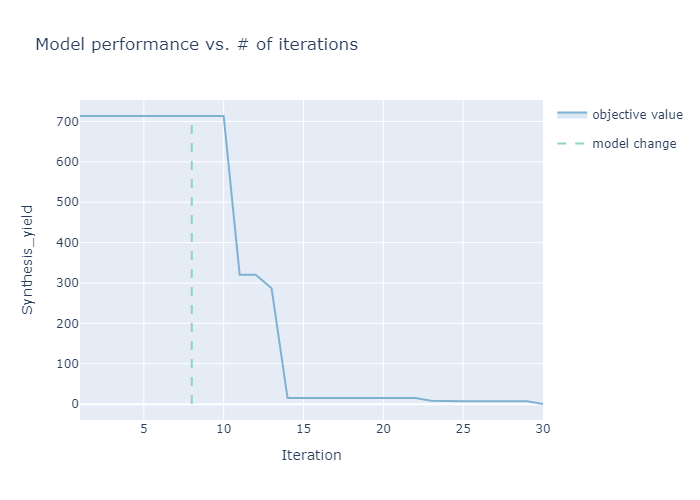

The best parameters were:


{'OSDA_molar_ratio': 0.34775812136334816,
 'H2O_molar_ratio': 12.389732172987166,
 'Synthesis_temperature': 138.9139401644853,
 'Synthesis_time': 25.450990377516668}


The objective value for the best parameters was:


{'Synthesis_yield': 0.8177388940177934}

In [4]:
optimize_experiment_ax(list_obj_names = ['Synthesis_yield'],
                       objective_function = dummy_function_4_continuous_1_objective,
                       continuous_parameters_list = [{"name": "OSDA_molar_ratio", "type": "range", "bounds": [0.1, 1.0]},
                                                     {"name": "H2O_molar_ratio", "type": "range", "bounds": [5.0, 100.0]},
                                                     {"name": "Synthesis_temperature", "type": "range", "bounds": [100.0, 200.0]},
                                                     {"name": "Synthesis_time", "type": "range", "bounds": [2.0, 432.0]},
                                                     ],
                       categorical_parameters_list = [],
                       parameter_constraints_lists = [],
                       iterations=30)

### 1.4 Multi-Objective with 4 Continuous Variables  <a name='Part1.4'></a>

The second demonstration uses the general function [`optimize_experiment_ax`](#Part1.2) to optimize an experiment with **4 continuous variables** with typical ranges that are based on [Table S4](https://pubs.acs.org/doi/suppl/10.1021/acs.chemmater.9b03738/suppl_file/cm9b03738_si_001.pdf#page=10) in the Supporting Information of [reference 1](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.9b03738): 
* the molar ratio of organic structure directing agents (OSDA) compared to Si  
* the molar ratio of water compared to Si
* synthesis temperature (°C)
* synthesis time (h)

The **2 target variables** are synthesis yield and DCC (divalent cation capacity). We assume that minimizing the above defined [dummy function](#Part1.1) `dummy_function_4_continuous_2_objective` corresponds to maximizing the yield and DCC of the zeolite synthesis. Refer to https://ax.dev/tutorials/multiobjective_optimization.html for more background information.

In [5]:
optimize_experiment_ax(list_obj_names = ['DCC', 'Synthesis_yield'],
                       objective_function = dummy_function_4_continuous_2_objective,
                       continuous_parameters_list = [{"name": "OSDA_molar_ratio", "type": "range", "bounds": [0.1, 1.0]},
                                                     {"name": "H2O_molar_ratio", "type": "range", "bounds": [5.0, 100.0]},
                                                     {"name": "Synthesis_temperature", "type": "range", "bounds": [100.0, 200.0]},
                                                     {"name": "Synthesis_time", "type": "range", "bounds": [2.0, 432.0]},
                                                     ],
                       categorical_parameters_list = [],
                       parameter_constraints_lists = [],
                       iterations=30)

The details of the last 5 experiments:


,Generation Step,Generation Model,Trial Index,Trial Status,Arm Parameterizations
25,GenerationStep_1,BoTorch,25,COMPLETED,"{'25_0': {'OSDA_molar_ratio': 0.35, 'H2O_molar_ratio': 12.76, 'Synthesis_temperature': 140.14, 'Synthesis_time': 23.7}}"
26,GenerationStep_1,BoTorch,26,COMPLETED,"{'26_0': {'OSDA_molar_ratio': 0.38, 'H2O_molar_ratio': 11.41, 'Synthesis_temperature': 140.21, 'Synthesis_time': 23.86}}"
27,GenerationStep_1,BoTorch,27,COMPLETED,"{'27_0': {'OSDA_molar_ratio': 0.36, 'H2O_molar_ratio': 13.2, 'Synthesis_temperature': 140.56, 'Synthesis_time': 23.78}}"
28,GenerationStep_1,BoTorch,28,COMPLETED,"{'28_0': {'OSDA_molar_ratio': 0.33, 'H2O_molar_ratio': 8.25, 'Synthesis_temperature': 143.34, 'Synthesis_time': 2.0}}"
29,GenerationStep_1,BoTorch,29,COMPLETED,"{'29_0': {'OSDA_molar_ratio': 0.35, 'H2O_molar_ratio': 12.67, 'Synthesis_temperature': 139.9, 'Synthesis_time': 30.48}}"


The Pareto optimal parameters were:


{'OSDA_molar_ratio': 0.3514134608325845,
 'H2O_molar_ratio': 12.763524283729826,
 'Synthesis_temperature': 140.14219782729086,
 'Synthesis_time': 23.698891067110903}


The objective values for the Pareto optimal parameters were:


{'DCC': 0.24512712912701318, 'Synthesis_yield': 0.04231119590133403}

### 1.5 Multi-Objective with 4 Continuous Variables and 2 Categorical Variables <a name='Part1.5'></a>

The third demonstration uses the general function [`optimize_experiment_ax`](#Part1.2) to optimize an experiment with **4 continuous variables** with typical ranges that are based on [Table S4](https://pubs.acs.org/doi/suppl/10.1021/acs.chemmater.9b03738/suppl_file/cm9b03738_si_001.pdf#page=10) in the Supporting Information of [reference 1](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.9b03738): 
* the molar ratio of organic structure directing agents (OSDA) compared to Si  
* the molar ratio of water compared to Si
* synthesis temperature (°C)
* synthesis time (h)

We also add **2 categorical variables** that are inspired of [Table S3](https://pubs.acs.org/doi/suppl/10.1021/jacs.1c07590/suppl_file/ja1c07590_si_001.pdf#page=9) in the Supporting Information of [reference 2](https://pubs.acs.org/doi/10.1021/jacs.1c07590): 
* Stirring mode: stirring (600 rpm), tumbling or static.  
* Silicon source: colloidal silica or fumed silica.

The **2 target variables** are synthesis yield and DCC (divalent cation capacity). We assume that minimizing the above defined [dummy function](#Part1.1) `dummy_function_4_continuous_2_categorical_2_objective` corresponds to maximizing the yield and DCC of the zeolite synthesis. Refer to https://ax.dev/tutorials/multiobjective_optimization.html for more background information.

In [13]:
optimize_experiment_ax(list_obj_names = ['DCC', 'Synthesis_yield'],
                       objective_function = dummy_function_4_continuous_2_categorical_2_objective,
                       continuous_parameters_list = [{"name": "OSDA_molar_ratio", "type": "range", "bounds": [0.1, 1.0]},
                                                     {"name": "H2O_molar_ratio", "type": "range", "bounds": [5.0, 100.0]},
                                                     {"name": "Synthesis_temperature", "type": "range", "bounds": [100.0, 200.0]},
                                                     {"name": "Synthesis_time", "type": "range", "bounds": [2.0, 432.0]},
                                                     ],
                       categorical_parameters_list = [{"name": "Stirring", "type": "choice", "is_ordered": False,"values": ["Stirring", "Tumbling", "Static"]},
                                                      {"name": "Silicon_source", "type": "choice", "is_ordered": False,"values": ["Colloidal", "Fumed"]},
                                                      ],
                       parameter_constraints_lists = [],
                       iterations=30)

The details of the last 5 experiments:


,Generation Step,Generation Model,Trial Index,Trial Status,Arm Parameterizations
25,GenerationStep_1,BoTorch,25,COMPLETED,"{'25_0': {'OSDA_molar_ratio': 0.35, 'H2O_molar_ratio': 12.04, 'Synthesis_temperature': 139.7, 'Synthesis_time': 27.79, 'Stirring': 'Static', 'Silicon_source': 'Fumed'}}"
26,GenerationStep_1,BoTorch,26,COMPLETED,"{'26_0': {'OSDA_molar_ratio': 0.34, 'H2O_molar_ratio': 11.67, 'Synthesis_temperature': 140.26, 'Synthesis_time': 25.62, 'Stirring': 'Static', 'Silicon_source': 'Fumed'}}"
27,GenerationStep_1,BoTorch,27,COMPLETED,"{'27_0': {'OSDA_molar_ratio': 0.35, 'H2O_molar_ratio': 12.09, 'Synthesis_temperature': 140.02, 'Synthesis_time': 29.19, 'Stirring': 'Static', 'Silicon_source': 'Fumed'}}"
28,GenerationStep_1,BoTorch,28,COMPLETED,"{'28_0': {'OSDA_molar_ratio': 0.34, 'H2O_molar_ratio': 12.8, 'Synthesis_temperature': 140.5, 'Synthesis_time': 26.23, 'Stirring': 'Static', 'Silicon_source': 'Fumed'}}"
29,GenerationStep_1,BoTorch,29,COMPLETED,"{'29_0': {'OSDA_molar_ratio': 0.34, 'H2O_molar_ratio': 12.48, 'Synthesis_temperature': 140.3, 'Synthesis_time': 27.02, 'Stirring': 'Static', 'Silicon_source': 'Fumed'}}"


The Pareto optimal parameters were:


{'OSDA_molar_ratio': 0.34576462735686786,
 'H2O_molar_ratio': 12.042266849002447,
 'Synthesis_temperature': 139.70090696302174,
 'Synthesis_time': 27.788607802183623,
 'Stirring': 'Static',
 'Silicon_source': 'Fumed'}


The objective values for the Pareto optimal parameters were:


{'DCC': 0.468011099197156, 'Synthesis_yield': 0.7500239907244577}

### 1.6 Multi-Objective with 4 Continuous Variables, 2 Categorical Variables and Parameter Constraints  <a name='Part1.6'></a>

The fourth demonstration uses the general function [`optimize_experiment_ax`](#Part1.2) to optimize an experiment with **4 continuous variables** with typical ranges that are based on [Table S4](https://pubs.acs.org/doi/suppl/10.1021/acs.chemmater.9b03738/suppl_file/cm9b03738_si_001.pdf#page=10) in the Supporting Information of [reference 1](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.9b03738): 
* the molar ratio of organic structure directing agents (OSDA) compared to Si  
* the molar ratio of water compared to Si
* synthesis temperature (°C)
* synthesis time (h)

We also add **2 categorical variables** that are inspired of [Table S3](https://pubs.acs.org/doi/suppl/10.1021/jacs.1c07590/suppl_file/ja1c07590_si_001.pdf#page=9) in the Supporting Information of [reference 2](https://pubs.acs.org/doi/10.1021/jacs.1c07590): 
* Stirring mode: stirring (600 rpm), tumbling or static.  
* Silicon source: colloidal silica or fumed silica.

Lastly, we add **one parameter constraint**. In the context of zeolite synthesis, parameter constraints are uncommon (the parameter bounds are sufficient), so we invent a physically meaningless constraint for illustrative purposes. This constraint will prevent attaining the global minimum, where approximately H2O_molar_ratio = 12.5 and Synthesis_temperature = 140
* (H2O_molar_ratio) + (Synthesis_temperature) <= 145

The **2 target variables** are synthesis yield and DCC (divalent cation capacity). We assume that minimizing the above defined [dummy function](#Part1.1) `dummy_function_4_continuous_2_categorical_2_objective` corresponds to maximizing the yield and DCC of the zeolite synthesis. Refer to https://ax.dev/tutorials/multiobjective_optimization.html for more background information.

In [7]:
optimize_experiment_ax(list_obj_names = ['DCC', 'Synthesis_yield'],
                       objective_function = dummy_function_4_continuous_2_categorical_2_objective,
                       continuous_parameters_list = [{"name": "OSDA_molar_ratio", "type": "range", "bounds": [0.1, 1.0]},
                                                     {"name": "H2O_molar_ratio", "type": "range", "bounds": [5.0, 100.0]},
                                                     {"name": "Synthesis_temperature", "type": "range", "bounds": [100.0, 200.0]},
                                                     {"name": "Synthesis_time", "type": "range", "bounds": [2.0, 432.0]},
                                                     ],
                       categorical_parameters_list = [{"name": "Stirring", "type": "choice", "is_ordered": False,"values": ["Stirring", "Tumbling", "Static"]},
                                                      {"name": "Silicon_source", "type": "choice", "is_ordered": False,"values": ["Colloidal", "Fumed"]},
                                                      ],
                       parameter_constraints_lists = ["H2O_molar_ratio + Synthesis_temperature <= 145.0"],
                       iterations=30)

The details of the last 5 experiments:


,Generation Step,Generation Model,Trial Index,Trial Status,Arm Parameterizations
25,GenerationStep_1,BoTorch,25,COMPLETED,"{'25_0': {'OSDA_molar_ratio': 0.35, 'H2O_molar_ratio': 8.65, 'Synthesis_temperature': 136.35, 'Synthesis_time': 22.99, 'Stirring': 'Static', 'Silicon_source': 'Fumed'}}"
26,GenerationStep_1,BoTorch,26,COMPLETED,"{'26_0': {'OSDA_molar_ratio': 0.34, 'H2O_molar_ratio': 8.55, 'Synthesis_temperature': 136.45, 'Synthesis_time': 23.4, 'Stirring': 'Static', 'Silicon_source': 'Fumed'}}"
27,GenerationStep_1,BoTorch,27,COMPLETED,"{'27_0': {'OSDA_molar_ratio': 0.34, 'H2O_molar_ratio': 8.08, 'Synthesis_temperature': 136.92, 'Synthesis_time': 20.49, 'Stirring': 'Static', 'Silicon_source': 'Fumed'}}"
28,GenerationStep_1,BoTorch,28,COMPLETED,"{'28_0': {'OSDA_molar_ratio': 0.34, 'H2O_molar_ratio': 8.05, 'Synthesis_temperature': 136.95, 'Synthesis_time': 18.65, 'Stirring': 'Static', 'Silicon_source': 'Fumed'}}"
29,GenerationStep_1,BoTorch,29,COMPLETED,"{'29_0': {'OSDA_molar_ratio': 0.34, 'H2O_molar_ratio': 8.49, 'Synthesis_temperature': 136.51, 'Synthesis_time': 23.21, 'Stirring': 'Static', 'Silicon_source': 'Fumed'}}"


The Pareto optimal parameters were:


{'OSDA_molar_ratio': 0.34503914342964936,
 'H2O_molar_ratio': 8.64551286485448,
 'Synthesis_temperature': 136.35448713516206,
 'Synthesis_time': 22.991767675435288,
 'Stirring': 'Static',
 'Silicon_source': 'Fumed'}


The objective values for the Pareto optimal parameters were:


{'DCC': 28.414187472214962, 'Synthesis_yield': 28.29822867583607}

### 1.7 Code Example without Using the General `optimize_experiment_ax` Function of Part 1.2  <a name='Part1.7'></a>

The fifth demonstration shows an experiment with **4 continuous variables** with typical ranges that are based on [Table S4](https://pubs.acs.org/doi/suppl/10.1021/acs.chemmater.9b03738/suppl_file/cm9b03738_si_001.pdf#page=10) in the Supporting Information of [reference 1](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.9b03738), but this time **without using the general function** [`optimize_experiment_ax`](#Part1.2). This is how one would probably use Ax when there is only one type of experiment. 

* the molar ratio of organic structure directing agents (OSDA) compared to Si  
* the molar ratio of water compared to Si
* synthesis temperature (°C)
* synthesis time (h)

The **single target variable** is synthesis yield. We assume that minimizing the above defined [dummy function](#Part1.1) `dummy_function_4_continuous_1_objective` corresponds to maximizing the yield of the zeolite synthesis. We also plot the **optimization trace** of the BO algorithm throughout the different experiment iterations.

The details of the last 5 experiment iterations:


,Generation Step,Generation Model,Trial Index,Trial Status,Arm Parameterizations
25,GenerationStep_1,BoTorch,25,COMPLETED,"{'25_0': {'OSDA_molar_ratio': 0.36, 'H2O_molar_ratio': 12.41, 'Synthesis_temperature': 140.96, 'Synthesis_time': 21.67}}"
26,GenerationStep_1,BoTorch,26,COMPLETED,"{'26_0': {'OSDA_molar_ratio': 0.37, 'H2O_molar_ratio': 11.45, 'Synthesis_temperature': 141.27, 'Synthesis_time': 2.0}}"
27,GenerationStep_1,BoTorch,27,COMPLETED,"{'27_0': {'OSDA_molar_ratio': 0.34, 'H2O_molar_ratio': 12.26, 'Synthesis_temperature': 139.76, 'Synthesis_time': 21.9}}"
28,GenerationStep_1,BoTorch,28,COMPLETED,"{'28_0': {'OSDA_molar_ratio': 0.1, 'H2O_molar_ratio': 5.0, 'Synthesis_temperature': 200.0, 'Synthesis_time': 2.0}}"
29,GenerationStep_1,BoTorch,29,COMPLETED,"{'29_0': {'OSDA_molar_ratio': 0.13, 'H2O_molar_ratio': 5.0, 'Synthesis_temperature': 132.33, 'Synthesis_time': 234.7}}"


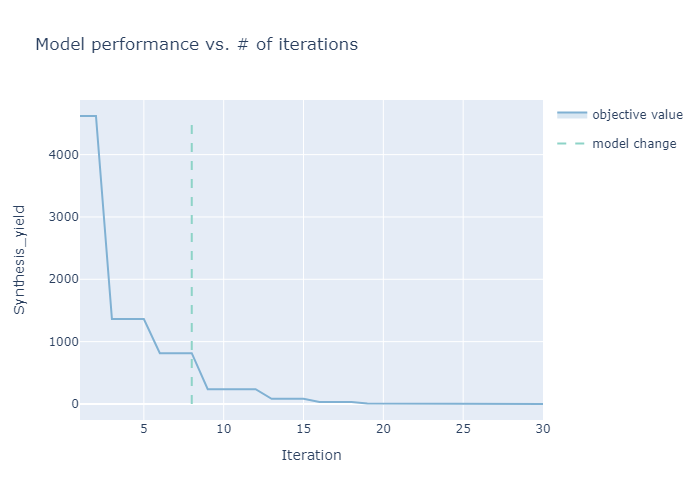

The best parameters were:


{'OSDA_molar_ratio': 0.34406537118593616,
 'H2O_molar_ratio': 12.255890900708632,
 'Synthesis_temperature': 139.7614030816516,
 'Synthesis_time': 21.90491099424178}


The objective value for the best parameters was:


{'Synthesis_yield': 0.4317714423295911}

In [7]:
obj_name1 = "Synthesis_yield"
  
ax_client = AxClient(verbose_logging=False)
ax_client.create_experiment(parameters=[{"name": "OSDA_molar_ratio", "type": "range", "bounds": [0.1, 1.0]},
                                        {"name": "H2O_molar_ratio", "type": "range", "bounds": [5.0, 100.0]},
                                        {"name": "Synthesis_temperature", "type": "range", "bounds": [100.0, 200.0]},
                                        {"name": "Synthesis_time", "type": "range", "bounds": [2.0, 432.0]},
                                        ],
                            objectives={obj_name1: ObjectiveProperties(minimize=True),},
                           )

for _ in range(30):
    parameterization, trial_index = ax_client.get_next_trial()

    # Extract parameters
    x1 = parameterization["OSDA_molar_ratio"]
    x2 = parameterization["H2O_molar_ratio"]
    x3 = parameterization["Synthesis_temperature"]
    x4 = parameterization["Synthesis_time"]
    
    results = dummy_function_4_continuous_1_objective(x1, x2, x3, x4, obj_name1=obj_name1)
    ax_client.complete_trial(trial_index=trial_index, raw_data=results)

best_parameters, value = ax_client.get_best_parameters()

# Create dataframe with details of all experiment iterations
df_experiments = ax_client.generation_strategy.trials_as_df
print('The details of the last 5 experiment iterations:')
display(df_experiments.tail())

# Get the AxClient's optimization trace using the built-in plotting method
optimization_trace = ax_client.get_optimization_trace()

# Convert the optimization trace to a Plotly figure and plot it
fig = to_plotly(optimization_trace)
fig.show(renderer='png')

# Output the best parameters and their corresponding objective values
print('The best parameters were:')
display(best_parameters)
print('\nThe objective value for the best parameters was:')
display(value[0])

## Part 2: Propose a New Experiment Based on a Batch of Prior (Literature) Experiments   <a name='Part2'></a>

Here Bayesian optimization is applied within a **real-world context** where the underlying target function remains unknown. We start from a batch of experiments collected from literature, and we allow the Bayesian optimizer to **suggest the next experiment**. This process aims to explore the search space further and/or leverage past results. In practice, one would carry out the suggested experiment, incorporate its outcome into the existing results, and subsequently rerun the Bayesian optimization algorithm.

### 2.1 Define a Function that Proposes the Next Best Experiment with Ax Package  <a name='Part2.1'></a>

Here we will create a **general function** `propose_experiment_ax` to propose a next best experiment with the Ax package. This general function allows focus on the output of the experiments further on, without repeatedly modifying similar sections of code. 

The `propose_experiment_ax` function takes a list of **continuous parameters**, a list of **categorical parameters**, a list of parameter **constraints**, a dataframe with **previous continuous experimental inputs**, a dataframe with **previous categorical experimental inputs** and a dictionary with **previous experimental outcomes (single or multi-objective)**. 

This function is inspired by the the following GitHub issue: https://github.com/Facebook/ax/issues/743.

In [9]:
def propose_experiment_ax(continuous_parameters_list, categorical_parameters_list, parameter_constraints_lists,
                          df_prior_experiments_input_continuous, df_prior_experiments_input_categorical, 
                          dictionary_prior_experiments_output):
    """
    Proposes the next best experiment with the Ax package. 
    Inputs: 
    continuous_parameters_list: list of continuous parameters for the objective function
    categorical_parameters_list: list of categorical parameters for the objective function
    parameter_constraints_lists: list of constraints in the parameter space
    df_prior_experiments_input_continuous: dataframe with the previous experimental inputs of the continuous parameters
    df_prior_experiments_input_categorical: dataframe with the previous experimental inputs of the categorical parameters
    dictionary_prior_experiments_output: a dictionary {objective_name : objective_result} in which objective_name is a string naming the objective,
                                         and objective_result is a pandas Series with the previous experimental outcomes 
    Outputs:
    A suggestion for the best subsequent experiment to try out.
    For single-objective experiments, the best previous parameters and their objective function output are printed.

    Source:
    This function is inspired by the following GitHub issue: https://github.com/Facebook/ax/issues/743 
    """
    all_parameters_list = continuous_parameters_list + categorical_parameters_list
    
    df_prior_experiments_input_all = pd.concat([df_prior_experiments_input_continuous, df_prior_experiments_input_categorical], axis=1)
    df_prior_experiments_output_all = pd.concat(dictionary_prior_experiments_output.values(), axis=1)
    df_prior_experiments_input_output_all = pd.concat([df_prior_experiments_input_all, df_prior_experiments_output_all], axis=1)
    print('The considered dataset with previous experimental inputs and outputs:')
    display(df_prior_experiments_input_output_all)

    objectives_dictionary={}
    for obj_name in dictionary_prior_experiments_output.keys():
        objectives_dictionary[obj_name]=ObjectiveProperties(minimize=False)
        
    # Skip the pseudo-random suggested points by specifying a custom generation strategy
    # See: https://ax.dev/tutorials/generation_strategy.html and
    # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
    gs = GenerationStrategy(steps=[GenerationStep(model=Models.GPEI, num_trials=-1, max_parallelism=3)])

    # Setup the experiment
    ax_client = AxClient(generation_strategy=gs, verbose_logging=False)
    ax_client.create_experiment(parameters=all_parameters_list, 
                                parameter_constraints=parameter_constraints_lists, 
                                objectives=objectives_dictionary)

    # Attach the training data
    for i in range(df_prior_experiments_input_all.shape[0]):
        ax_client.attach_trial(df_prior_experiments_input_all.iloc[i, :].to_dict())

        result_dictionary={}
        for obj_name in dictionary_prior_experiments_output.keys():
            # We assume standard error is 0.0
            result_dictionary[obj_name] = (dictionary_prior_experiments_output[obj_name][i], 0.0)
        ax_client.complete_trial(trial_index=i, raw_data=result_dictionary)
        
    # Produce a single next suggested experiment
    next_experiment, trial_index = ax_client.get_next_trial()
    print("\nNext suggested experiment:" )
    display(next_experiment)

    if len(dictionary_prior_experiments_output.keys()) == 1 :
        # Single-objective experiment
        # Output the best parameters and their corresponding objective values
        best_parameters, value = ax_client.get_best_parameters()
        print('\nThe best parameters were:')
        display(best_parameters)
        print('\nThe objective value for the best parameters was:')
        display(value[0])
       
    return None

### 2.2 Collect the Literature Input and Output Data  <a name='Part2.2'></a>

The objective of the considered study was to find a one-pot synthesis of Fe-CHA zeolites that maximizes the methanol yield when the synthesized material is activated and reacted with methane. 'One-pot' means that Fe is already added in the zeolite synthesis, instead of being post-synthetically ion-exchanged on the zeolite.

The input literature data are based on [Table S3](https://pubs.acs.org/doi/suppl/10.1021/jacs.1c07590/suppl_file/ja1c07590_si_001.pdf#page=9) in the Supporting Information of [reference 2](https://pubs.acs.org/doi/10.1021/jacs.1c07590). A reasonable value was chosen for missing data.

The **continuous** variables are:
* the molar ratio of organic structure directing agents, OSDA, compared to Si  
* the molar ratio of water compared to Si
* the molar ratio of Fe compared to Si

The **categorical** variables are:
* Fe source: iron(III) acetate (A) or iron(III)  nitrate (N).
* Stirring mode: stirring (600 rpm) or static.

The **2 target variables** are based on respectively [Table S3](https://pubs.acs.org/doi/suppl/10.1021/jacs.1c07590/suppl_file/ja1c07590_si_001.pdf#page=9) and [Table S4](https://pubs.acs.org/doi/suppl/10.1021/jacs.1c07590/suppl_file/ja1c07590_si_001.pdf#page=10) in the Supporting Information of [reference 2](https://pubs.acs.org/doi/10.1021/jacs.1c07590):
* Zeolite synthesis yield 
* Methanol yield (MeOH/Al)


In [10]:
parameter_names = ["OSDA_molar_ratio", "H2O_molar_ratio", "Fe_molar_ratio", "Fe_Salt", "Stirring"]

X_train = np.array([[0.36, 15.4, 0.019, 'A', 'Static'],
                    [0.33, 14.1, 0.016, 'A', 'Static'],
                    [0.36, 15.5, 0.018, 'N', 'Static'],
                    [0.36, 15.5, 0.017, 'N', 'Static'],
                    [0.36, 15.5, 0.035, 'A', 'Static'],
                    [0.36, 15.5, 0.037, 'N', 'Stirring'],
                    [0.34, 14.4, 0.039, 'N', 'Stirring'],
                    [0.36, 15.5, 0.055, 'A', 'Static'],
                    [0.36, 15.6, 0.055, 'N', 'Static'],
                    [0.36, 15.5, 0.090, 'A', 'Static'],
                    [0.33, 14.1, 0.016, 'A', 'Stirring'],
                    ])

X_train = pd.DataFrame(X_train, columns=parameter_names)
dict_types = {'OSDA_molar_ratio': 'float64', 'H2O_molar_ratio': 'float64', 'Fe_molar_ratio': 'float64', 
              'Fe_Salt': 'object', 'Stirring': 'object' }
X_train = X_train.astype(dict_types)

y_train_yield = np.array([0.83, 0.85, 0.96, 0.84, 0.93, 1.0, 0.91, 0.0, 0.0, 0.0, 0.91])
y_train_methanol = np.array([0.089, 0.085, 0.084, 0.108, 0.116, 0.063, 0.108, 0.053, 0.013, 0.020, 0.062])

print('\nLiterature input data with the experimental Synthesis_yield and Methanol_yield outcome. This will be fed as prior information to BO:')
X_total = X_train.copy()
X_total['Synthesis_yield'] = y_train_yield.tolist()
X_total['Methanol_yield'] = y_train_methanol.tolist()
display(X_total)
display(X_total.dtypes)



Literature input data with the experimental Synthesis_yield and Methanol_yield outcome. This will be fed as prior information to BO:


,OSDA_molar_ratio,H2O_molar_ratio,Fe_molar_ratio,Fe_Salt,Stirring,Synthesis_yield,Methanol_yield
0,0.36,15.4,0.019,A,Static,0.83,0.089
1,0.33,14.1,0.016,A,Static,0.85,0.085
2,0.36,15.5,0.018,N,Static,0.96,0.084
3,0.36,15.5,0.017,N,Static,0.84,0.108
4,0.36,15.5,0.035,A,Static,0.93,0.116
5,0.36,15.5,0.037,N,Stirring,1.00,0.063
6,0.34,14.4,0.039,N,Stirring,0.91,0.108
7,0.36,15.5,0.055,A,Static,0.00,0.053
8,0.36,15.6,0.055,N,Static,0.00,0.013
9,0.36,15.5,0.090,A,Static,0.00,0.020


OSDA_molar_ratio    float64
H2O_molar_ratio     float64
Fe_molar_ratio      float64
Fe_Salt              object
Stirring             object
Synthesis_yield     float64
Methanol_yield      float64
dtype: object

### 2.3 Single-Objective (Synthesis Yield) with 3 Continuous Variables and 2 Categorical Variables  <a name='Part2.3'></a>

In this scenario, we are interested in **maximizing the zeolite synthesis yield** (single-objective). We run [`propose_experiment_ax`](#Part2.1) to generate the next best experiment to try out in the labaratory. 

In [11]:
propose_experiment_ax(continuous_parameters_list = [{"name": "OSDA_molar_ratio", "type": "range", "bounds": [0.30, 0.40]},
                                                    {"name": "H2O_molar_ratio",  "type": "range", "bounds": [14.0, 16.0]},
                                                    {"name": "Fe_molar_ratio",   "type": "range", "bounds": [0.01, 0.10]},
                                                   ],
                      categorical_parameters_list = [{"name": "Fe_Salt", "type": "choice", "is_ordered": False,"values": ["A", "N"]},
                                                     {"name": "Stirring", "type": "choice", "is_ordered": False, "values": ["Stirring", "Static"]},
                                                    ],     
                      parameter_constraints_lists = [],
                      df_prior_experiments_input_continuous  = X_total[["OSDA_molar_ratio", "H2O_molar_ratio", "Fe_molar_ratio"]],
                      df_prior_experiments_input_categorical = X_total[["Fe_Salt", "Stirring"]],
                      dictionary_prior_experiments_output = {"Synthesis_yield" : X_total.loc[:,"Synthesis_yield"]} 
                     )
 

The considered dataset with previous experimental inputs and outputs:


,OSDA_molar_ratio,H2O_molar_ratio,Fe_molar_ratio,Fe_Salt,Stirring,Synthesis_yield
0,0.36,15.4,0.019,A,Static,0.83
1,0.33,14.1,0.016,A,Static,0.85
2,0.36,15.5,0.018,N,Static,0.96
3,0.36,15.5,0.017,N,Static,0.84
4,0.36,15.5,0.035,A,Static,0.93
5,0.36,15.5,0.037,N,Stirring,1.00
6,0.34,14.4,0.039,N,Stirring,0.91
7,0.36,15.5,0.055,A,Static,0.00
8,0.36,15.6,0.055,N,Static,0.00
9,0.36,15.5,0.090,A,Static,0.00



Next suggested experiment:


{'OSDA_molar_ratio': 0.3597986726498765,
 'H2O_molar_ratio': 15.488919708603255,
 'Fe_molar_ratio': 0.023291856734901355,
 'Fe_Salt': 'N',
 'Stirring': 'Static'}


The best parameters were:


{'OSDA_molar_ratio': 0.36,
 'H2O_molar_ratio': 15.5,
 'Fe_molar_ratio': 0.037,
 'Fe_Salt': 'N',
 'Stirring': 'Stirring'}


The objective value for the best parameters was:


{'Synthesis_yield': 1.0}

### 2.4 Multi-Objective (Synthesis Yield + Methanol Production) with 3 Continuous Variables and 2 Categorical Variables <a name='Part2.4'></a>

In this scenario, we are interested in **maximizing both the zeolite synthesis yield and the methanol production** (multi-objective). We run [`propose_experiment_ax`](#Part2.1) to generate the next best experiment to try out in the labaratory. 

In [12]:
propose_experiment_ax(continuous_parameters_list = [{"name": "OSDA_molar_ratio", "type": "range", "bounds": [0.30, 0.40]},
                                                    {"name": "H2O_molar_ratio",  "type": "range", "bounds": [14.0, 16.0]},
                                                    {"name": "Fe_molar_ratio",   "type": "range", "bounds": [0.01, 0.10]},
                                                   ],
                      categorical_parameters_list = [{"name": "Fe_Salt", "type": "choice", "is_ordered": False,"values": ["A", "N"]},
                                                     {"name": "Stirring", "type": "choice", "is_ordered": False, "values": ["Stirring", "Static"]},
                                                    ],     
                      parameter_constraints_lists = [],
                      df_prior_experiments_input_continuous  = X_total[["OSDA_molar_ratio", "H2O_molar_ratio", "Fe_molar_ratio"]],
                      df_prior_experiments_input_categorical = X_total[["Fe_Salt", "Stirring"]],
                      dictionary_prior_experiments_output = {"Synthesis_yield" : X_total.loc[:,"Synthesis_yield"], 
                                                             "Methanol_yield" : X_total.loc[:,"Methanol_yield"],
                                                            } 
                     ) 

The considered dataset with previous experimental inputs and outputs:


,OSDA_molar_ratio,H2O_molar_ratio,Fe_molar_ratio,Fe_Salt,Stirring,Synthesis_yield,Methanol_yield
0,0.36,15.4,0.019,A,Static,0.83,0.089
1,0.33,14.1,0.016,A,Static,0.85,0.085
2,0.36,15.5,0.018,N,Static,0.96,0.084
3,0.36,15.5,0.017,N,Static,0.84,0.108
4,0.36,15.5,0.035,A,Static,0.93,0.116
5,0.36,15.5,0.037,N,Stirring,1.00,0.063
6,0.34,14.4,0.039,N,Stirring,0.91,0.108
7,0.36,15.5,0.055,A,Static,0.00,0.053
8,0.36,15.6,0.055,N,Static,0.00,0.013
9,0.36,15.5,0.090,A,Static,0.00,0.020



Next suggested experiment:


{'OSDA_molar_ratio': 0.3526783041131582,
 'H2O_molar_ratio': 15.331573897619075,
 'Fe_molar_ratio': 0.033573534446308506,
 'Fe_Salt': 'A',
 'Stirring': 'Static'}